# **E-mail campaign effectiveness**



Most of the small to medium business owners are making effective use of Gmail-based
Email marketing Strategies for offline targeting of converting their prospective customers into
leads so that they stay with them in Business.

The main objective is to create a machine learning model to characterize the mail and track
the mail that is ignored; read; acknowledged by the reader.

Data columns are self-explanatory.

## **Read data** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold,\
RandomizedSearchCV, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, recall_score ,\
auc, precision_score,f1_score


from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

from collections import Counter

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [4]:
data = pd.read_csv('/content/drive/MyDrive/data_email_campaign.csv')
data.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0


In [5]:
# Quite a few null values
# Nothing major
# target_variable has no missing values

data.isnull().sum()

Email_ID                         0
Email_Type                       0
Subject_Hotness_Score            0
Email_Source_Type                0
Customer_Location            11595
Email_Campaign_Type              0
Total_Past_Communications     6825
Time_Email_sent_Category         0
Word_Count                       0
Total_Links                   2201
Total_Images                  1677
Email_Status                     0
dtype: int64

In [6]:
# Email ID feature can be dropped

print(data.shape)
data['Email_ID'].nunique()

(68353, 12)


68353

In [7]:
print(data.describe(include=['object', 'category']).columns)
data.describe(include=['int', 'float']).columns

Index(['Email_ID', 'Customer_Location'], dtype='object')


Index(['Email_Type', 'Subject_Hotness_Score', 'Email_Source_Type',
       'Email_Campaign_Type', 'Total_Past_Communications',
       'Time_Email_sent_Category', 'Word_Count', 'Total_Links', 'Total_Images',
       'Email_Status'],
      dtype='object')

In [8]:
data.isnull().sum()

Email_ID                         0
Email_Type                       0
Subject_Hotness_Score            0
Email_Source_Type                0
Customer_Location            11595
Email_Campaign_Type              0
Total_Past_Communications     6825
Time_Email_sent_Category         0
Word_Count                       0
Total_Links                   2201
Total_Images                  1677
Email_Status                     0
dtype: int64

In [9]:
# Tentative : 0 - Ignored;  1 - Read;  2 - Replied / Acknowledged
# Highly imbalanced data
# 24:5:1

target_variable = 'Email_Status'
data['Email_Status'].value_counts()

0    54941
1    11039
2     2373
Name: Email_Status, dtype: int64

## **EDA**

In [10]:
# Create a copy of data 
# var - df

df = data.copy()

In [11]:
# Cursory analysis shows
# Email_Source_Type, Email_Campaign_Type, Time_Email_sent_Category are numerical
# with discrete integer values (categorical type)

# May make model biased

df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0


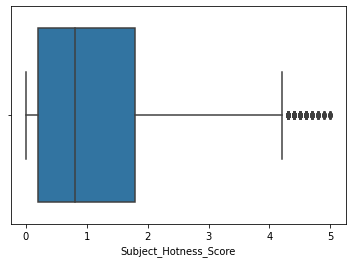

In [12]:
# To find the distribution of 'Subject_Hotness_Score'
# It should not exceed 5 

sns.boxplot(x = df['Subject_Hotness_Score'])

In [13]:
df.head(3)

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1


In [14]:
# Email_ID is a useless variable
# Cant be used as index either
# df = df.drop('Email_ID', axis = 1 )

In [15]:
print(df.shape)
df.sample(7)

(68353, 12)


,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
24285,EMA00083170820240,1,2.0,2,G,2,22.0,2,741,11.0,0.0,0
60358,EMA00086401925570,1,1.1,2,NaN,2,20.0,3,704,16.0,10.0,0
19890,EMA00082777565700,1,1.0,2,G,2,34.0,2,678,21.0,18.0,1
42368,EMA00084785989330,1,0.7,1,G,2,50.0,2,578,6.0,0.0,1
48676,EMA00085353706940,1,3.2,1,E,2,25.0,1,314,21.0,10.0,1
40798,EMA00084646968590,1,1.5,2,G,2,14.0,2,842,5.0,0.0,0
61675,EMA00086520145110,1,0.7,1,NaN,2,40.0,1,392,6.0,1.0,0


In [16]:
df.shape

(68353, 12)

In [17]:
# Finding the pure numerical variables
# cat_variables_type contains - cat + numerical-categorical
# numerical_variables - Purely numerical features

cat_variables_type = []

for x in df.describe(include='all').columns:
    if df[x].nunique ()< 10 :
      print (x , df[x].nunique())
      cat_variables_type.append(x)

cat_variables_type.remove(target_variable)

print("\n",cat_variables_type)



numerical_variables = list(df.describe().columns)
numerical_variables = list(set(numerical_variables).difference(set(cat_variables_type)))

numerical_variables.remove(target_variable)
numerical_variables

Email_Type 2
Email_Source_Type 2
Customer_Location 7
Email_Campaign_Type 3
Time_Email_sent_Category 3
Email_Status 3

 ['Email_Type', 'Email_Source_Type', 'Customer_Location', 'Email_Campaign_Type', 'Time_Email_sent_Category']


['Subject_Hotness_Score',
 'Total_Links',
 'Word_Count',
 'Total_Past_Communications',
 'Total_Images']

In [18]:
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0


### **Missing Values**

In [19]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

print("Percentage missing : {:.3%} ".format(total_missing/total_cells))

df.isnull().sum()

del(missing_values_count)
del(total_cells)
del(total_missing)

Percentage missing : 2.718% 


In [20]:
null_columns = []
for x,y in dict(zip(df.isnull().sum().index, df.isnull().sum())).items():
  if y > 0:
    null_columns.append(x)

null_columns

del(x)
del(y)

for x in null_columns:
  if df[x].dtype == 'object':
    df[x] = df[x].fillna(df[x].value_counts().index[0])
  
  else: 
    df[x] = df[x].fillna(df[x].median())

del(x)
del(null_columns)

In [21]:
# This should show all 0s
df.isnull().sum()

Email_ID                     0
Email_Type                   0
Subject_Hotness_Score        0
Email_Source_Type            0
Customer_Location            0
Email_Campaign_Type          0
Total_Past_Communications    0
Time_Email_sent_Category     0
Word_Count                   0
Total_Links                  0
Total_Images                 0
Email_Status                 0
dtype: int64

### **Exploration - Numerical**

In [22]:
# Changing the float values to int values
# Candidates - 
# Total_Past_Communications, Total_Links, Total_Images


# df['Total_Links'].value_counts().sort_index()
df['Total_Links'] = df['Total_Links'].astype(int)

# df['Total_Images'].value_counts().sort_index()
df['Total_Images'] = df['Total_Images'].astype(int)

# df['Total_Past_Communications'].value_counts().sort_index()
df['Total_Past_Communications'] = df['Total_Past_Communications'].astype(int)

df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,G,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0
4,EMA00081000109720,1,0.0,2,C,3,18,2,947,4,0,0


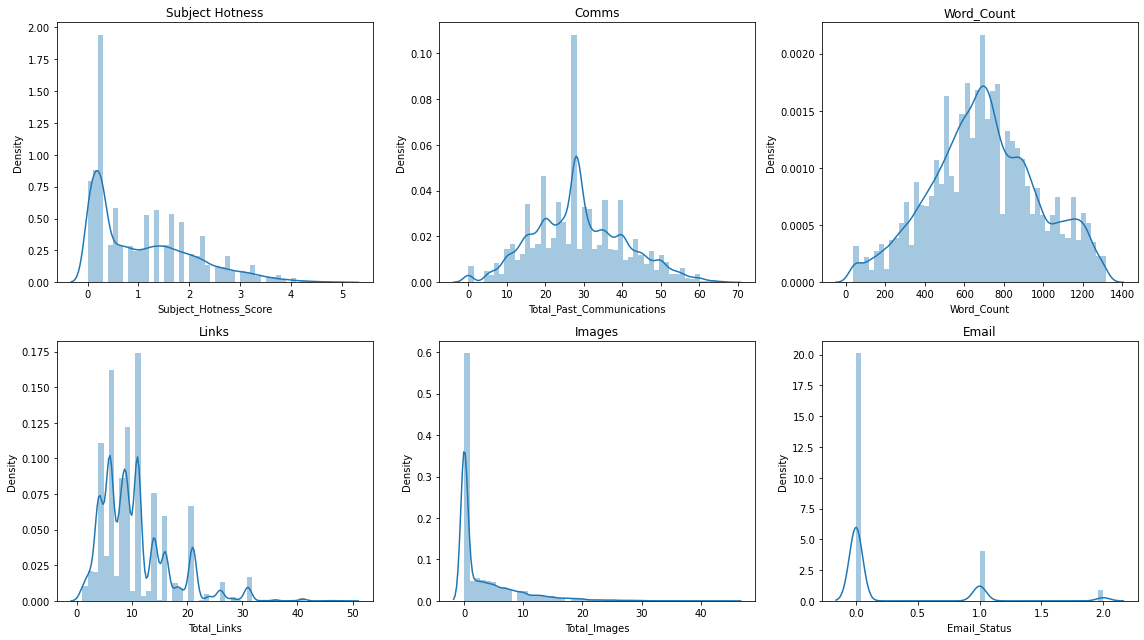

In [23]:
# To observe the distributions
# Skew here is expected
# Will have some outliers
# Mostly right skewed

plt.figure(figsize = (16,9))



plt.subplot(2,3,1)
plt.title('Subject Hotness')
sns.distplot(a = df['Subject_Hotness_Score'])

plt.subplot(2,3,2)
plt.title('Comms')
sns.distplot(a = df['Total_Past_Communications'])

plt.subplot(2,3,3)
plt.title('Word_Count')
sns.distplot(a = df['Word_Count'])

plt.subplot(2,3,4)
plt.title('Links')
sns.distplot(a = df['Total_Links'])

plt.subplot(2,3,5)
plt.title('Images')
sns.distplot(a = df['Total_Images'])

plt.subplot(2,3,6)
plt.title('Email')
sns.distplot(a = df['Email_Status'])

plt.tight_layout()
plt.show()


In [24]:
df.head(4)

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,G,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0


In [25]:
# To show the class distribution
# Note minority and majority 

Counter(df['Email_Status'])

Counter({0: 54941, 1: 11039, 2: 2373})

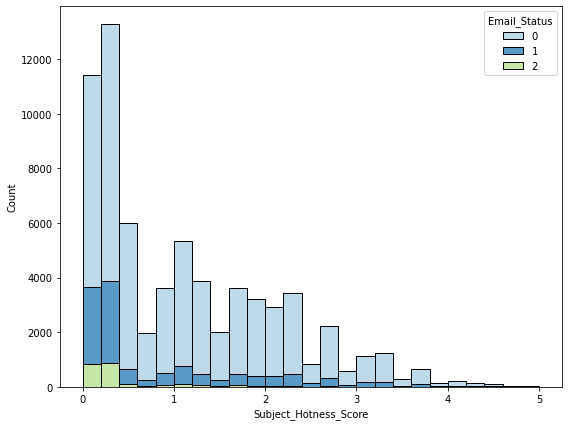

In [26]:
# This shows distribution of classes 
# Minority classes 1 , 2 : Related to low subject hotness score
# 

plt.figure(figsize = (9,7))
sns.histplot(data = df, x = 'Subject_Hotness_Score', hue = 'Email_Status', bins = 25, palette = 'Paired', multiple = 'stack')
plt.show()

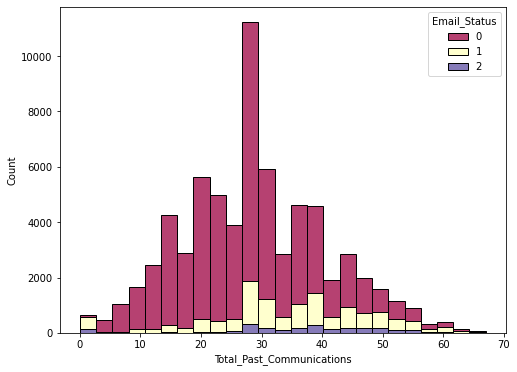

In [27]:
# color_palettes can also be : vlag, icefire, spectral, etc
# Higher number of Total_Past_Communications more chances for 
# Email_Status -1,2


plt.figure(figsize = (8,6))
sns.histplot(data = df, x = 'Total_Past_Communications', hue = 'Email_Status', bins = 25, palette = 'Spectral', multiple = 'stack')
plt.show()

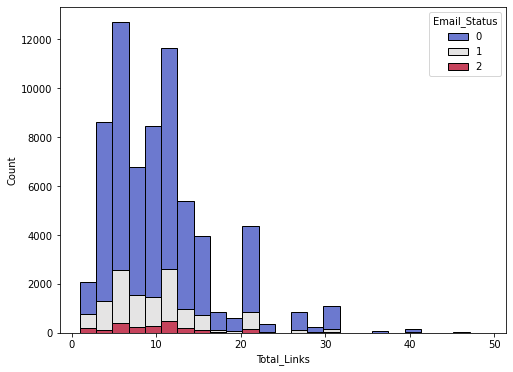

In [28]:
# Lower number of Total_Past_Communications more chances for 
# Email_Status -1,2

plt.figure(figsize = (8,6))
sns.histplot(data = df, x = 'Total_Links', hue = 'Email_Status', bins = 25, palette = 'coolwarm', multiple = 'stack')
plt.show()

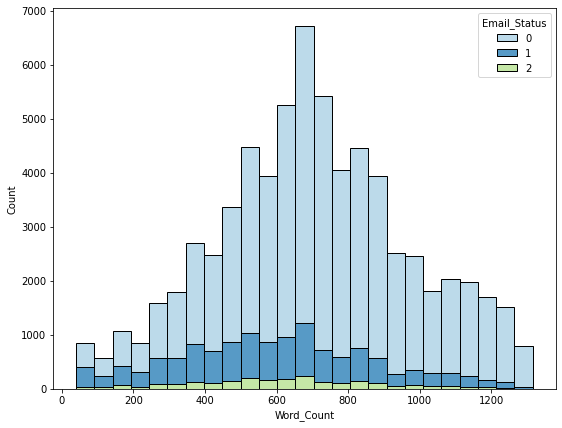

In [29]:
# Normally distibuted over Word_Count
# Follows normal pattern distribution

plt.figure(figsize = (9,7))
sns.histplot(data = df, x = 'Word_Count', hue = 'Email_Status', bins = 25, palette = 'Paired', multiple = 'stack')
plt.show()

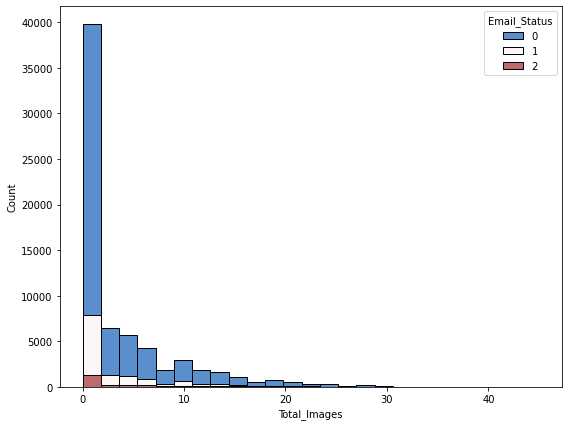

In [30]:
# Distribution over Total_Images
# Low value of Total_Images explains most of 0 and 1 


plt.figure(figsize = (9,7))
sns.histplot(data = df, x = 'Total_Images', hue = 'Email_Status', bins = 25, palette = 'vlag', multiple = 'stack')
plt.show()

In [31]:
numerical_variables.append('Email_Status')
X = df.loc[:, numerical_variables].copy()
X.shape

(68353, 6)

In [32]:
numerical_variables

['Subject_Hotness_Score',
 'Total_Links',
 'Word_Count',
 'Total_Past_Communications',
 'Total_Images',
 'Email_Status']

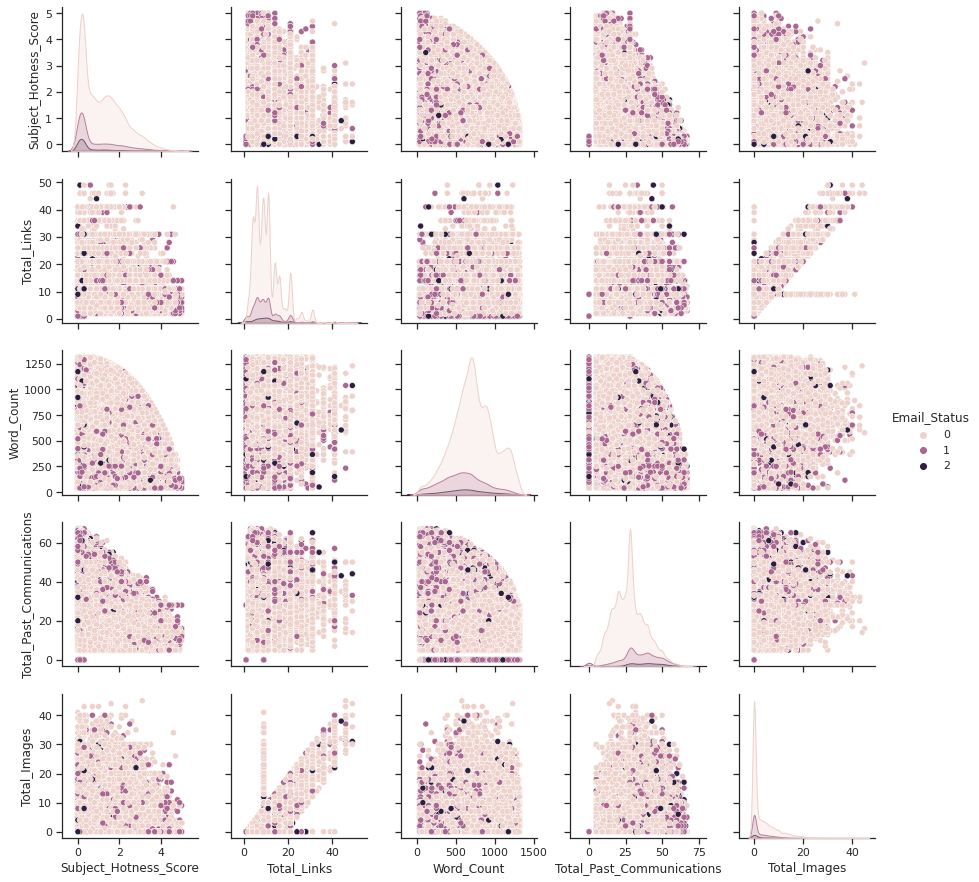

In [33]:
sns.set_theme(style="ticks")
sns.pairplot(X, hue='Email_Status')

In [34]:
X.shape

(68353, 6)

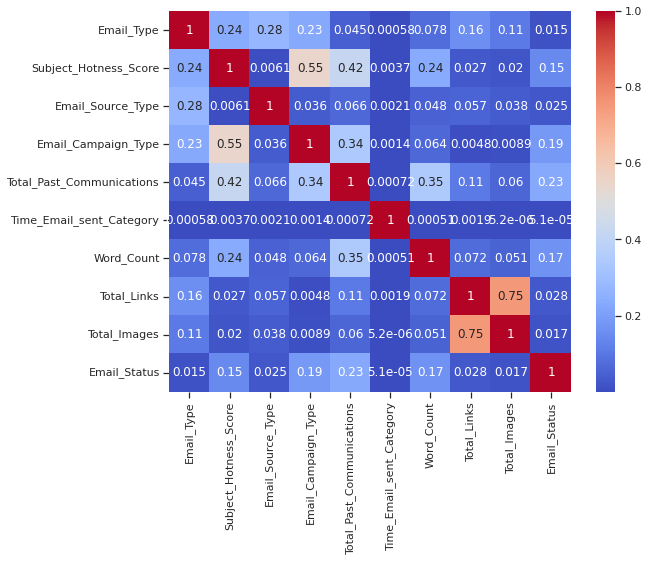

In [35]:
# Total Links and Total Images are heavily correlated

plt.figure(figsize = (9,7))
correlation = df.corr()
sns.heatmap(abs(correlation), cmap = 'coolwarm', annot = True)

In [36]:
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,G,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0
4,EMA00081000109720,1,0.0,2,C,3,18,2,947,4,0,0


### **Outliers - Numerical**

In [37]:
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,G,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0
4,EMA00081000109720,1,0.0,2,C,3,18,2,947,4,0,0


In [38]:
numerical_variables

['Subject_Hotness_Score',
 'Total_Links',
 'Word_Count',
 'Total_Past_Communications',
 'Total_Images',
 'Email_Status']

In [39]:
numerical_variables.remove('Email_Status')

In [40]:
numerical_variables

['Subject_Hotness_Score',
 'Total_Links',
 'Word_Count',
 'Total_Past_Communications',
 'Total_Images']

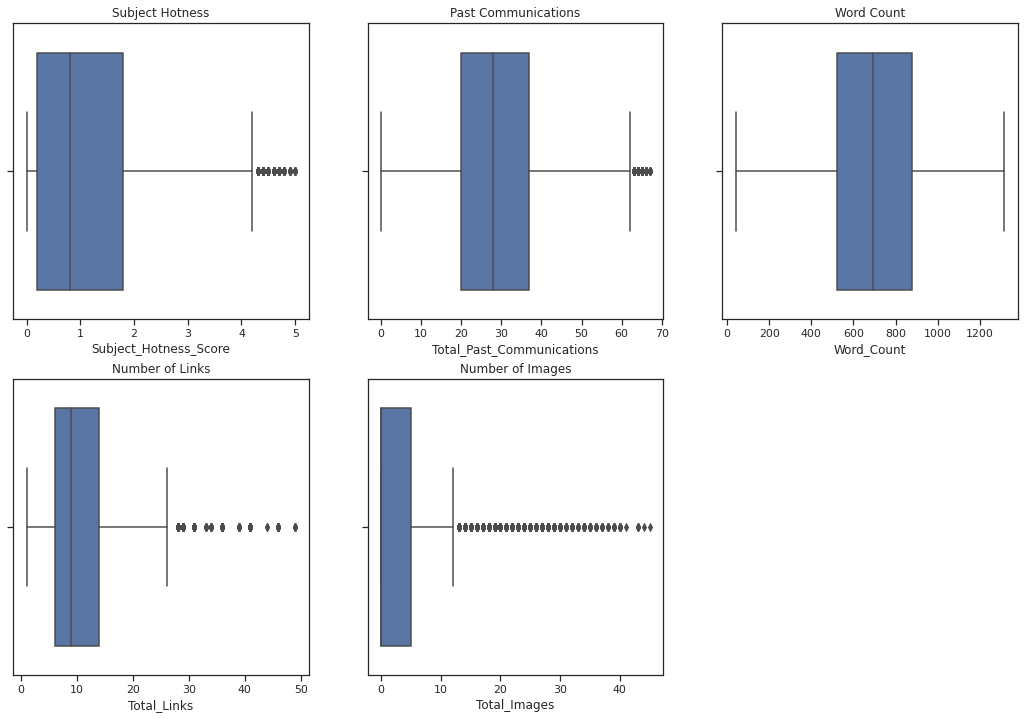

In [41]:
# Only word Count does not have outliers

plt.figure(figsize =(18,12))
plt.subplot(2,3,1)
plt.title('Subject Hotness')
sns.boxplot(x = df['Subject_Hotness_Score'])

plt.subplot(2,3,2)
plt.title('Past Communications')
sns.boxplot(x = df['Total_Past_Communications'])


plt.subplot(2,3,3)
plt.title('Word Count')
sns.boxplot(x = df['Word_Count'])

plt.subplot(2,3,4)
plt.title('Number of Links')
sns.boxplot(x = df['Total_Links'])

plt.subplot(2,3,5)
plt.title('Number of Images')
sns.boxplot(x = df['Total_Images'])


In [42]:
# Inter Qaurtile Range for numerical variables

Q1 = df[numerical_variables].quantile(0.25)
Q3 = df[numerical_variables].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Subject_Hotness_Score          1.6
Total_Links                    8.0
Word_Count                   359.0
Total_Past_Communications     17.0
Total_Images                   5.0
dtype: float64


In [43]:
# To find the indices of the rows sample the feature has an outlier
# There seems to be plenty of rows where the feature is an outlier 
# number of rows : ~8 %

outliers_index = set()
for x in numerical_variables:

  Q1 = df[x].quantile(0.25)
  Q3 = df[x].quantile(0.75)
  IQR = Q3 - Q1
  outliers_index.update(df.loc[(df[x]> Q3 + 1.5 * IQR) | (df[x]< Q1 - 1.5 * IQR)].index)

outliers_index

len(outliers_index)

6096

In [44]:
df.shape

(68353, 12)

### **Exploration - Categorical**

In [45]:
cat_variables_type

['Email_Type',
 'Email_Source_Type',
 'Customer_Location',
 'Email_Campaign_Type',
 'Time_Email_sent_Category']

In [46]:
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,G,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0
4,EMA00081000109720,1,0.0,2,C,3,18,2,947,4,0,0


In [47]:
# This is pretty useless
# Borrowed from '/content/drive/MyDrive/Colab Notebooks/project-cardiovascular_risk.ipynb'
# Requires plenty of modification

'''
def get_labels_values(feature):

  feature_values = []

  for x in sorted(list(feature.unique())):
    feature_values.append((df.loc[feature==x][df[target_variable]==0].shape[0],
                           df.loc[feature==x][df[target_variable]==1].shape[0],
                           df.loc[feature==x][df[target_variable]==2].shape[0]))

# Will give percentage of feature variable when target_variable == 0

  for x,y in enumerate(feature_values):
    feature_values[x] = y[0]/(y[0]+y[1]+y[2]) * 100

  labels = sorted(list(feature.unique()))

  return labels, feature_values

'''

'\ndef get_labels_values(feature):\n\n  feature_values = []\n\n  for x in sorted(list(feature.unique())):\n    feature_values.append((df.loc[feature==x][df[target_variable]==0].shape[0],\n                           df.loc[feature==x][df[target_variable]==1].shape[0],\n                           df.loc[feature==x][df[target_variable]==2].shape[0]))\n\n# Will give percentage of feature variable when target_variable == 0\n\n  for x,y in enumerate(feature_values):\n    feature_values[x] = y[0]/(y[0]+y[1]+y[2]) * 100\n\n  labels = sorted(list(feature.unique()))\n\n  return labels, feature_values\n\n'

In [48]:
def get_labels_values(feature):

# Gives the percetange of feature_variable matching target_variable = [0,1,2]
# Then you can find out distributions for each target_variable

  feature_values = []
  list_un = []
  for x in sorted(df[target_variable].unique()):
    list_un = []
    for y in sorted(feature.unique()):
      list_un.append(df.loc[(df[target_variable]==x) & (feature==y)].shape[0])
    else :
      feature_values.append(tuple(list_un))

  labels = sorted(list(feature.unique()))
  
  return labels, feature_values

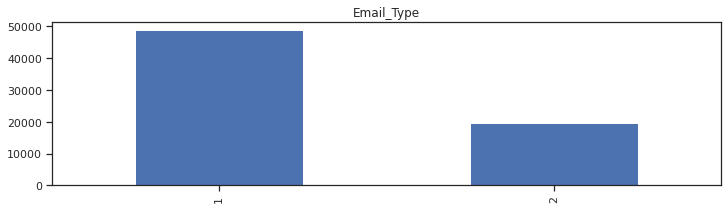

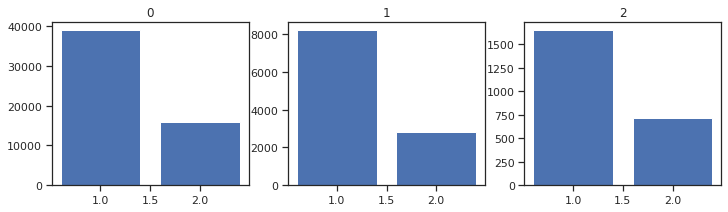

In [49]:
# There will be 4 plots
# 1 - feature.value_counts()
# 2,3,4 - feature values distribution

plt.figure(figsize = (12,3))
#plt.subplot(1,4,1)
plt.title('Email_Type')
df['Email_Type'].value_counts().sort_index().plot.bar()
plt.show()
labels,y = get_labels_values(df['Email_Type'])

plt.figure(figsize = (12,3))
for x in range(1, len(y)+ 1): 
  
  plt.subplot(1,3,x)
  plt.title(str(x-1))
  plt.bar(labels, y[x -1])

In [50]:
cat_variables_type

['Email_Type',
 'Email_Source_Type',
 'Customer_Location',
 'Email_Campaign_Type',
 'Time_Email_sent_Category']

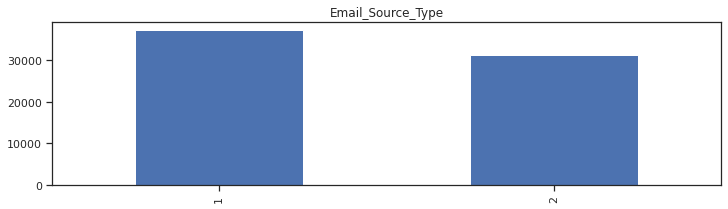

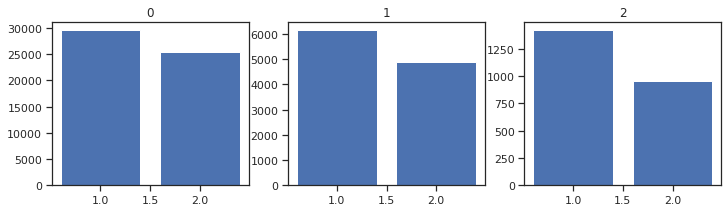

In [51]:
plt.figure(figsize = (12,3))
#plt.subplot(1,4,1)
plt.title('Email_Source_Type')
df['Email_Source_Type'].value_counts().sort_index().plot.bar()
plt.show()
labels,y = get_labels_values(df['Email_Source_Type'])

plt.figure(figsize = (12,3))
for x in range(1, len(y)+ 1): 
  
  plt.subplot(1,3,x)
  plt.title(str(x-1))
  plt.bar(labels, y[x -1])

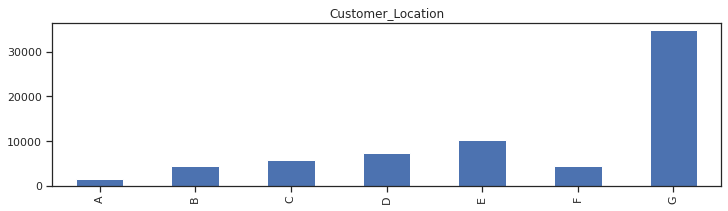

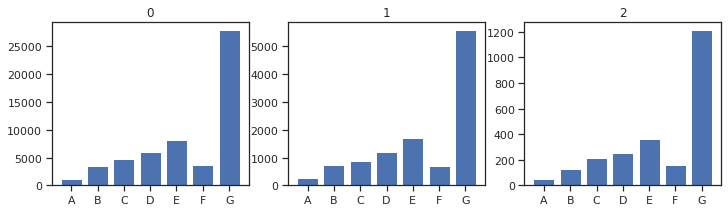

In [52]:
plt.figure(figsize = (12,3))
#plt.subplot(1,4,1)
plt.title('Customer_Location')
df['Customer_Location'].value_counts().sort_index().plot.bar()
plt.show()
labels,y = get_labels_values(df['Customer_Location'])

plt.figure(figsize = (12,3))
for x in range(1, len(y)+ 1): 
  
  plt.subplot(1,3,x)
  plt.title(str(x-1))
  plt.bar(labels, y[x -1])

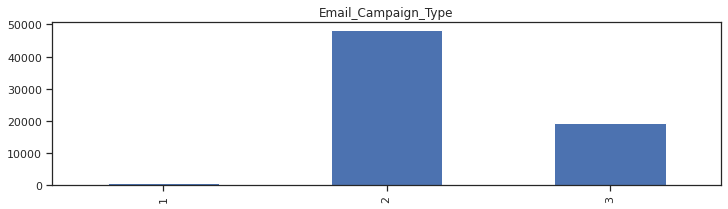

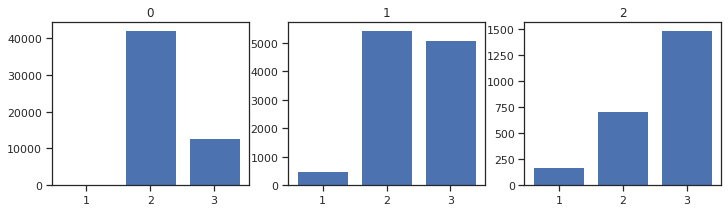

In [53]:
plt.figure(figsize = (12,3))
#plt.subplot(1,4,1)
plt.title('Email_Campaign_Type')
df['Email_Campaign_Type'].value_counts().sort_index().plot.bar()
plt.show()
labels,y = get_labels_values(df['Email_Campaign_Type'])

plt.figure(figsize = (12,3))
for x in range(1, len(y)+ 1): 
  
  plt.subplot(1,3,x)
  plt.title(str(x-1))
  plt.bar(labels, y[x -1])

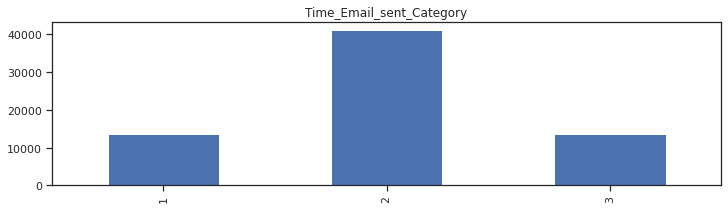

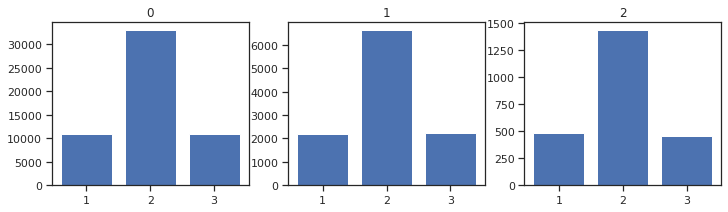

In [54]:
plt.figure(figsize = (12,3))
#plt.subplot(1,4,1)
plt.title('Time_Email_sent_Category')
df['Time_Email_sent_Category'].value_counts().sort_index().plot.bar()
plt.show()
labels,y = get_labels_values(df['Time_Email_sent_Category'])

plt.figure(figsize = (12,3))
for x in range(1, len(y)+ 1): 
  
  plt.subplot(1,3,x)
  plt.title(str(x-1))
  plt.bar(labels, y[x -1])

## **Mutual Information**

In [55]:
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,G,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0
4,EMA00081000109720,1,0.0,2,C,3,18,2,947,4,0,0


In [56]:
X = df.copy()
y = X.pop("Email_Status")
X = X.drop('Email_ID', axis = 1)

In [57]:
X.shape

(68353, 10)

In [58]:
# Factorizing the columns

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [59]:
def plot_mi_scores(scores):

    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

Total_Past_Communications    0.0590
Email_Campaign_Type          0.0426
Word_Count                   0.0293
Subject_Hotness_Score        0.0224
Total_Links                  0.0179
Total_Images                 0.0011
Email_Type                   0.0004
Email_Source_Type            0.0003
Customer_Location            0.0001
Time_Email_sent_Category     0.0000
Name: MI Scores, dtype: float64


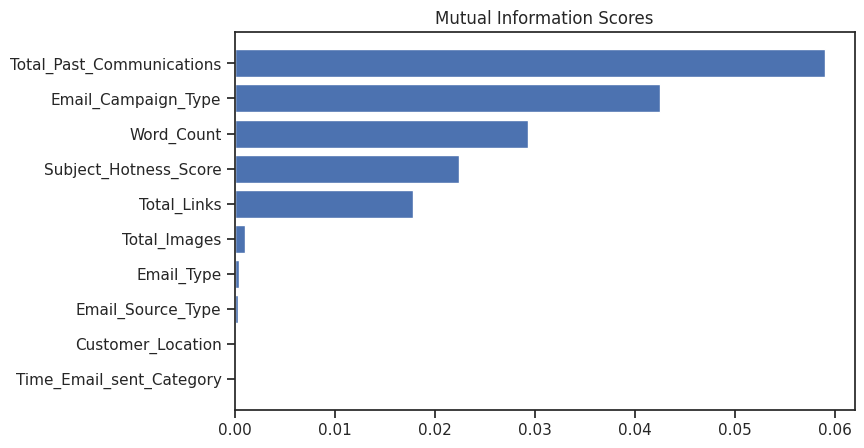

In [60]:
mi_scores = make_mi_scores(X, y, discrete_features)
# show a few features with their MI scores
print(round(mi_scores, 4))
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)


## **Model - 1 : Data Prep + Cross Val**

Here cross validation is performed on the dataset\
It shows poor results when using the appropriate metric

In [61]:
df.head(3)

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,G,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1


In [62]:
X = df.copy()
X = X.drop('Email_ID', axis = 1)

y = X[target_variable].copy()
X = X.drop('Email_Status', axis = 1)


In [63]:
# To find the categorical variables that need to be One Hot Encoded
# Only Customer_Location seems to be the one that should be changed

cat_variables_type
X.loc[:3, cat_variables_type]

,Email_Type,Email_Source_Type,Customer_Location,Email_Campaign_Type,Time_Email_sent_Category
0,1,2,E,2,1
1,2,1,G,2,2
2,2,1,B,3,2
3,1,2,E,2,2


In [64]:
X = pd.get_dummies(X, columns=['Customer_Location'], prefix=["Cust_Loc"])

X.head()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Cust_Loc_A,Cust_Loc_B,Cust_Loc_C,Cust_Loc_D,Cust_Loc_E,Cust_Loc_F,Cust_Loc_G
0,1,2.2,2,2,33,1,440,8,0,0,0,0,0,1,0,0
1,2,2.1,1,2,15,2,504,5,0,0,0,0,0,0,0,1
2,2,0.1,1,3,36,2,962,5,0,0,1,0,0,0,0,0
3,1,3.0,2,2,25,2,610,16,0,0,0,0,0,1,0,0
4,1,0.0,2,3,18,2,947,4,0,0,0,1,0,0,0,0


In [65]:
print(X.shape)
#X = X.values
#y = y.values

print(data['Email_Status'].value_counts())
Counter(y)

(68353, 16)
0    54941
1    11039
2     2373
Name: Email_Status, dtype: int64


Counter({0: 54941, 1: 11039, 2: 2373})

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [75]:
# number of features at every split
max_features = ['auto', 'log2', None]
criterion = ['gini', 'entropy', 'log_loss']

# max depth
max_depth = [int(x) for x in np.linspace(5, 10, 4)]
max_depth.append(None)

min_impurity_decrease = [x for x in np.arange(0.025, 0.2, 0.025)]
max_leaf_nodes = [x for x in np.arange(5, 11, 1)]

# create random grid
random_grid = {
  'criterion': criterion,
  'max_features': max_features,
  'max_depth': max_depth,
  'min_impurity_decrease': min_impurity_decrease,
  'max_leaf_nodes' : max_leaf_nodes

 }
 
 # Random search of parameters
rcv_classifier = DecisionTreeClassifier()
rcv = RandomizedSearchCV(estimator = rcv_classifier,
                          param_distributions = random_grid,
                          n_iter = 100, cv = 5, verbose=2,
                          scoring = 'f1_macro',
                          random_state=42, n_jobs = -1)

# Fit the model
rcv.fit(X, y)

# print results
print(rcv.best_params_)
print(rcv.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'min_impurity_decrease': 0.1, 'max_leaf_nodes': 9, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
0.29707312062731145


In [76]:
rcv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.1}

=== Confusion Matrix ===


<Figure size 432x288 with 0 Axes>

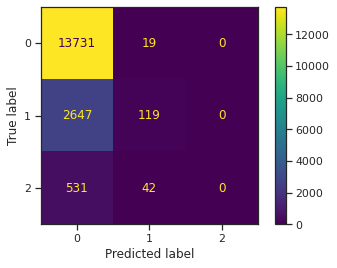

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     13750
           1       0.66      0.04      0.08      2766
           2       0.00      0.00      0.00       573

    accuracy                           0.81     17089
   macro avg       0.49      0.35      0.33     17089
weighted avg       0.76      0.81      0.73     17089
 

=== All CV Scores ===
[0.81070802 0.80866004 0.8108543  0.80892465 0.80950988 0.80965618
 0.80936357 0.80892465 0.81053402 0.81053402] 

=== Mean CV Score ===
Mean f1 Score - Random Forest:  0.8097669316407863


In [77]:
# Use the parameters from the RandomSearchCV for the next 
# This shows that the resampling will be required
# 

dt_classifier = DecisionTreeClassifier(criterion= 'entropy',max_depth = None,
                                       max_features= None, max_leaf_nodes = 9,
                                       min_impurity_decrease= 0.01)

dt_classifier.fit(X_train,y_train)
dt_predict = dt_classifier.predict(X_test)
dt_cv_score = cross_val_score(dt_classifier, X, y, cv=10, scoring='f1_micro')

print("=== Confusion Matrix ===")

plt.figure()
plot_confusion_matrix(dt_classifier, X_test, y_test)
plt.show()

print("=== Classification Report ===")
print(classification_report(y_test, dt_predict), "\n")

print("=== All CV Scores ===")
print(dt_cv_score, "\n")

print("=== Mean CV Score ===")
print("Mean f1 Score - Random Forest: ", dt_cv_score.mean())

This shows that the resampling will be required


In [78]:
f1_score(y_test, dt_predict, average = 'macro')

0.3255038131562762

[Text(0.5, 0.875, 'X[3] <= 2.5\nentropy = 0.848\nsamples = 51264\nvalue = [41191, 8273, 1800]'),
 Text(0.25, 0.625, 'X[3] <= 1.5\nentropy = 0.658\nsamples = 36751\nvalue = [31652, 4439, 660]'),
 Text(0.125, 0.375, 'entropy = 1.227\nsamples = 556\nvalue = [58, 367, 131]'),
 Text(0.375, 0.375, 'X[6] <= 522.5\nentropy = 0.615\nsamples = 36195\nvalue = [31594, 4072, 529]'),
 Text(0.25, 0.125, 'entropy = 0.929\nsamples = 9522\nvalue = [7188, 2068, 266]'),
 Text(0.5, 0.125, 'entropy = 0.464\nsamples = 26673\nvalue = [24406, 2004, 263]'),
 Text(0.75, 0.625, 'X[4] <= 27.5\nentropy = 1.194\nsamples = 14513\nvalue = [9539, 3834, 1140]'),
 Text(0.625, 0.375, 'entropy = 0.549\nsamples = 3701\nvalue = [3312, 331, 58]'),
 Text(0.875, 0.375, 'entropy = 1.318\nsamples = 10812\nvalue = [6227, 3503, 1082]')]

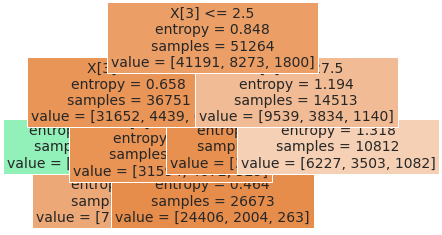

In [79]:
# Visualize the tree
from sklearn import tree 

tree.plot_tree(dt_classifier,
               filled=True, fontsize=14)

## **Model - 2** 

Here we shall oversample using SMOTE.\
The oversampled dataset will have 54000 * 3
samples.

Compare with the other model to evaluate 
performance.
Model 1 failed to generalise over Email_Status 
class - 1 and 2

In [85]:
X = df.copy()
X = X.drop('Email_ID', axis = 1)
y = X[target_variable].copy()
X = X.drop(target_variable, axis = 1 )

X = pd.get_dummies(X, columns=['Customer_Location'], prefix=["Cust_Loc"])
X.head()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Cust_Loc_A,Cust_Loc_B,Cust_Loc_C,Cust_Loc_D,Cust_Loc_E,Cust_Loc_F,Cust_Loc_G
0,1,2.2,2,2,33,1,440,8,0,0,0,0,0,1,0,0
1,2,2.1,1,2,15,2,504,5,0,0,0,0,0,0,0,1
2,2,0.1,1,3,36,2,962,5,0,0,1,0,0,0,0,0
3,1,3.0,2,2,25,2,610,16,0,0,0,0,0,1,0,0
4,1,0.0,2,3,18,2,947,4,0,0,0,1,0,0,0,0


In [86]:
# The value_counts of target variable
# Ratio : 24:5:1

print(X.shape)
print(data['Email_Status'].value_counts())
Counter(y)

(68353, 16)
0    54941
1    11039
2     2373
Name: Email_Status, dtype: int64


Counter({0: 54941, 1: 11039, 2: 2373})

In [87]:
# This was rather easy compared to the above code

smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

print(y_smote.shape)
print(X_smote.shape)

(164823,)
(164823, 16)


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=324)

In [89]:
print(X_train.shape)
X_test.shape

(131858, 16)


(32965, 16)

In [ ]:
# number of features at every split
max_features = ['auto', 'log2', None]
criterion = ['gini', 'entropy', 'log_loss']

# max depth
max_depth = [int(x) for x in np.linspace(5, 10, 4)]
max_depth.append(None)

# min_impurity_decrease
min_impurity_decrease = [x for x in np.arange(0.025, 0.2, 0.025)]

# max_leaf_nodes
max_leaf_nodes = [x for x in np.arange(5, 11, 1)]

# n_estimators
n_estimators = [x for x in np.arange(50, 110 , 10)] 

# create random grid
random_grid = {
  'n_estimators': n_estimators,
  'criterion': criterion,
  'max_features': max_features,
  'max_depth': max_depth,
  'min_impurity_decrease': min_impurity_decrease,
  'max_leaf_nodes' : max_leaf_nodes

 }
 
 # Random search of parameters
rcv_classifier = RandomForestClassifier()
rcv = RandomizedSearchCV(estimator = rcv_classifier,
                          param_distributions = random_grid,
                          n_iter = 100, cv = 5, verbose=2,
                          scoring = 'roc_auc',
                          random_state=42, n_jobs = -1)

# Fit the model
rcv.fit(X, y)

# print results
print(rcv.best_params_)
print(rcv.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
# Clearly Overfit to the value with highest number of samples
# The model is biased to the majority class
# Class imbalance is there
# 0 -   54941     1-  11039     2-     2373

rf_classifier = RandomForestClassifier(n_estimators = 500, 
                                        max_leaf_nodes = None, max_features = None,
                                        max_depth = None, criterion = 'entropy')

rf_classifier.fit(X_train,y_train)
rf_predict = rf_classifier.predict(X_test)
# rfc_cv_score = cross_val_score(rf_classifier, X, y, cv=10, scoring='f1_micro')

print("=== Confusion Matrix ===")

plt.figure()
plot_confusion_matrix(rf_classifier, X_test, y_test)
plt.show()

'''
print("=== All AUC Scores ===")
print(rfc_cv_score, "\n")

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
'''

In [ ]:
print(f1_score(y_test, rf_predict, average= None))
# type(f1_score(y_test, y_test_pred, average= None))